# LABELLING - ACTIVE LEARNING

In [1]:
%pip install transformers datasets evaluate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
import json

c:\Users\Jonathan\Desktop\F20AA - Applied Text Analytics\CW1\F20AA_Grp5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Labelling and Finetuning functions

In [3]:
'''
Function that labels the data with the provided model
and saves the labeled data to a csv file. Additionally,
it saves 100 rows with the lowest RoBERTa confidence scores
to a new CSV file.

Params:
model - the model to be used for sentiment analysis
tokenizer - the tokenizer to be used for sentiment analysis
dataset - dataframe containing the entire dataset
round - active learning round
'''
def label_data(model, tokenizer, dataset, round):
  # Initialize the sentiment analysis pipeline
  sentiment_pipeline = pipeline("text-classification", 
                                model=model,
                                tokenizer=tokenizer,
                                device=0) 
  
  # Extract the text column of selected_data as a list
  reviews = dataset["text"].tolist()
    
  # Calculate the sentiment of the each of the reviews
  print(f"\nRound {round} - Automated Labelling ")
  print("Predicting sentiment labels of data...")

  kwargs = {'padding':True,'truncation':True,'max_length':512}
  results = sentiment_pipeline(reviews, **kwargs) 

  print("Sentiment labels predicted.")
  print("Saving labeled data to a csv files...")

  # Add the sentiment and score to the selected_data DataFrame
  label2id = {"positive": 1, "negative": -1, "neutral": 0}
  dataset["roberta_label"] = [label2id[res["label"]] for res in results]
  dataset["roberta_score"] = [res["score"] for res in results]

  # Save the labeled data to a csv file
  dataset.to_csv(f'../Data/Labelling/round{round}_roberta_labelled_all_data.csv', index=False)

  # Save 100 rows with the lowest RoBERTa confidence scores to a new CSV file
  df_low_confidence = dataset.nsmallest(100, 'roberta_score')
  df_low_confidence.to_csv(f'../Data/Labelling/round{round}_roberta_labelled_low_confidence.csv', index=False)
  
  print(f"Completed Round {round} - Automated Labeling")

  return dataset

In [4]:
# Load, process and tokenize the manual train and eval data for each round
def process_manual_data(tokenizer, round):

  # Wait till user confirms that the manual data is ready
  input(f"Please ensure that the manual data for round {round} is ready. Press Enter to continue...")
  
  # Load the manual data for the round, and all the rounds before it (to retain previously learnt patterns)
  train_data = pd.read_csv(f'../Data/Labelling/Manual/round{round}_manual_low_confidence.csv')
  for i in range(1, round):
    round_data = pd.read_csv(f'../Data/Labelling/Manual/round{i}_manual_low_confidence.csv')
    train_data = pd.concat([train_data, round_data], ignore_index=True)

  val_data = pd.read_csv(f'../Data/Labelling/Manual/manual_val_set.csv')

  # Drop all columns except the text and the manual label
  train_data.drop(columns=[col for col in train_data.columns if col not in ['text', 'manual_label']], inplace=True)
  val_data.drop(columns=[col for col in val_data.columns if col not in ['text', 'manual_label']], inplace=True)

  # Drop the duplicates from the training manual data, keeping the first occurence (latest label)
  train_data.drop_duplicates(subset=['text'], keep='first', inplace=True)

  # Drop the rows which are NaN, or contain '2' values in the manual_label column (rows marked irrelevant during manual labelling)
  train_data = train_data[train_data['manual_label'] != 2].dropna()

  # Rename the manual_label column to labels
  train_data.rename(columns={'manual_label':'labels'}, inplace=True)
  val_data.rename(columns={'manual_label':'labels'}, inplace=True)

  # Map the labels to the model's labels
  # 0 -> Negative, 1 -> Neutral, 2, Positive

  label2id = {-1: 0, 0: 1, 1: 2}
  train_data['labels'] = train_data['labels'].map(label2id)
  val_data['labels'] = val_data['labels'].map(label2id)

  # Print the number of rows in the training and validation data
  print(f"Round {round} - Training data: {train_data.shape[0]} rows")
  print(f"Round {round} - Validation data: {val_data.shape[0]} rows")
  
  # Convert to Dataset object
  train_data = Dataset.from_pandas(train_data)
  val_data = Dataset.from_pandas(val_data)
  
  # Tokenize the data using the model's tokenizer
  train_data_tokenized = train_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  val_data_tokenized = val_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  # Combine the train and val datasets
  train_val_dataset = DatasetDict({"train": train_data_tokenized, "val": val_data_tokenized})

  print(f"Round {round} - Manual data loaded and processed.")

  return train_val_dataset
    

In [5]:
# Function to compute the metrics for the model
def compute_metrics(eval_preds):
    # Load the metrics - accuracy and f1 score
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    # Extract the logits and true labels from the predictions
    logits, true_labels = eval_preds

    # Compute the predicted label (label with the highest logit score)
    pred_labels = np.argmax(logits, axis=-1)

    # Compute the metrics using the true and predicted labels
    computed_metrics = accuracy.compute(predictions=pred_labels, 
                                        references=true_labels)
    
    computed_metrics.update(f1.compute(predictions=pred_labels,
                                references=true_labels,
                                average = 'weighted'))   
                                
    return computed_metrics

In [6]:
# Reference: https://huggingface.co/docs/transformers/en/training
def finetune(model, dataset, tokenizer, round):
  # Define a data collator object for dynamic padding (padding to the maximum length of the batch)
  data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

  # Configure the training arguments
  training_arguments = TrainingArguments(
    output_dir = f'../Models/round{round}_finetuned_model_checkpoints/',
    num_train_epochs = 3,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    )
  
  trainer = Trainer(
    model,
    training_arguments,
    train_dataset = dataset['train'],
    eval_dataset = dataset['val'],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
  )

  print(f"\nRound {round} - Fine-tuning the model...")

  trainer.train()

  # Calculate the metrics on the validation set
  eval_results = trainer.evaluate()
  print(f"Round {round} - Evaluation results: {eval_results}")

  # Save evaluation results to a json file
  with open(f'../Models/Evaluation/round{round}_finetuned_model_eval_results.json', 'w') as f:
    json.dump(eval_results, f, indent=4)
    

  trainer.save_model(f'../Models/round{round}_finetuned_model')
  print(f"Round {round} - Model fine-tuned.")

  # Return the finetuned model
  return trainer.model

In [7]:
# Function to conduct one round of active learning
def active_learning(pretrained_model, dataset, tokenizer, round):
  print (f"Round {round} of Active Learning")

  # 1. Load the model
  if round == 1:
    # For round 1, load the pretrained model
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
  else:
    # For subsequent rounds, load the finetuned model from the previous round
    model = AutoModelForSequenceClassification.from_pretrained(f'../Models/round{round-1}_finetuned_model')
      
  # 2. Using the model, automatically label the entire dataset
  label_data(model = model, 
            dataset = dataset, 
            tokenizer = tokenizer,
            round = round)
  
  # 3. Load the manually labeled data, including the newly labeled data from the previous round
  train_val_data = process_manual_data(tokenizer = tokenizer,
                                    round = round) 
  
  # 4. Fine-tune the model on the manually labeled data
  finetune(model = model, 
          dataset = train_val_data,
          tokenizer = tokenizer,
          round = round)
      
  print (f"Completed Round {round} of Active Learning")


## 2. Run Active Learning Loop

Active learning allows us to manually label the most informative parts of the dataset that confuses the model the most. 

In [8]:
# Load the selected data, and tokenizer
pretrained_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
dataset = pd.read_csv('../Data/selected_data.csv')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [9]:
# Conduct active learning - round 1
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 1)

Round 1 of Active Learning


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Round 1 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 1 - Automated Labeling
Round 1 - Training data: 73 rows
Round 1 - Validation data: 199 rows


Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 1 - Manual data loaded and processed.

Round 1 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.366000,1.076808,0.376884,0.278355
2,1.011800,1.046965,0.457286,0.395463
3,0.878800,1.013552,0.497487,0.446973


Round 1 - Evaluation results: {'eval_loss': 1.0135518312454224, 'eval_accuracy': 0.49748743718592964, 'eval_f1': 0.4469728556358892, 'eval_runtime': 2.7767, 'eval_samples_per_second': 71.669, 'eval_steps_per_second': 9.004, 'epoch': 3.0}
Round 1 - Model fine-tuned.
Completed Round 1 of Active Learning


In [10]:
# Conduct active learning - round 2
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 2)

Device set to use cuda:0


Round 2 of Active Learning

Round 2 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 2 - Automated Labeling
Round 2 - Training data: 122 rows
Round 2 - Validation data: 199 rows


Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 2 - Manual data loaded and processed.

Round 2 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.869900,0.892357,0.577889,0.581322
2,0.384400,1.077947,0.582915,0.588859
3,0.144600,1.298432,0.537688,0.538050


Round 2 - Evaluation results: {'eval_loss': 1.2984318733215332, 'eval_accuracy': 0.5376884422110553, 'eval_f1': 0.5380503960378121, 'eval_runtime': 2.7009, 'eval_samples_per_second': 73.679, 'eval_steps_per_second': 9.256, 'epoch': 3.0}
Round 2 - Model fine-tuned.
Completed Round 2 of Active Learning


In [12]:
# Conduct active learning - round 3
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 3)

Device set to use cuda:0


Round 3 of Active Learning

Round 3 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 3 - Automated Labeling
Round 3 - Training data: 197 rows
Round 3 - Validation data: 199 rows


Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 3 - Manual data loaded and processed.

Round 3 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654700,1.153739,0.608040,0.609870
2,0.309000,1.292932,0.613065,0.617172
3,0.081800,1.621248,0.557789,0.557597


Round 3 - Evaluation results: {'eval_loss': 1.6212475299835205, 'eval_accuracy': 0.5577889447236181, 'eval_f1': 0.5575971518645427, 'eval_runtime': 45.3196, 'eval_samples_per_second': 4.391, 'eval_steps_per_second': 0.552, 'epoch': 3.0}
Round 3 - Model fine-tuned.
Completed Round 3 of Active Learning


In [13]:
# Conduct active learning - round 4
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 4)

Device set to use cuda:0


Round 4 of Active Learning

Round 4 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 4 - Automated Labeling
Round 4 - Training data: 274 rows
Round 4 - Validation data: 199 rows


Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 4 - Manual data loaded and processed.

Round 4 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.548100,1.366003,0.567839,0.567688
2,0.244700,1.919846,0.592965,0.595628
3,0.109700,2.434428,0.542714,0.534644


Round 4 - Evaluation results: {'eval_loss': 2.4344277381896973, 'eval_accuracy': 0.542713567839196, 'eval_f1': 0.5346436812867987, 'eval_runtime': 2.7587, 'eval_samples_per_second': 72.136, 'eval_steps_per_second': 9.062, 'epoch': 3.0}
Round 4 - Model fine-tuned.
Completed Round 4 of Active Learning


In [14]:
# Conduct active learning - round 5
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 5)

Device set to use cuda:0


Round 5 of Active Learning

Round 5 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 5 - Automated Labeling
Round 5 - Training data: 337 rows
Round 5 - Validation data: 199 rows


Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 5 - Manual data loaded and processed.

Round 5 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.495200,2.673341,0.472362,0.460750
2,0.392700,2.345308,0.603015,0.605168
3,0.132100,2.364025,0.597990,0.601961


Round 5 - Evaluation results: {'eval_loss': 2.364025115966797, 'eval_accuracy': 0.5979899497487438, 'eval_f1': 0.6019612564274126, 'eval_runtime': 2.762, 'eval_samples_per_second': 72.05, 'eval_steps_per_second': 9.052, 'epoch': 3.0}
Round 5 - Model fine-tuned.
Completed Round 5 of Active Learning


## 3. Dataset Compilation

Now that the active learning-driven labelling process has been complete, we will combine the 5 manually labelled datasets that were produced in each round of the active learning, along with the final automatically labelled dataset from our finetuned Sentiment Analysis Transformer model.

In [7]:
# Read the required datasets for compilation
round1_manual_df = pd.read_csv('../Data/Labelling/Manual/round1_manual_low_confidence.csv')
round2_manual_df = pd.read_csv('../Data/Labelling/Manual/round2_manual_low_confidence.csv')
round3_manual_df = pd.read_csv('../Data/Labelling/Manual/round3_manual_low_confidence.csv')
round4_manual_df = pd.read_csv('../Data/Labelling/Manual/round4_manual_low_confidence.csv')
round5_manual_df = pd.read_csv('../Data/Labelling/Manual/round5_manual_low_confidence.csv')
final_automatic_df = pd.read_csv('../Data/Labelling/round5_roberta_labelled_all_data.csv')

In [17]:
# Preprocess the manual data for compilation
for manual_df in [round1_manual_df, round2_manual_df, round3_manual_df, round4_manual_df, round5_manual_df]:
  # Drop irrelevant columns from each manual_df, and rename the manual_label column to label
  manual_df.drop(columns=['roberta_label', 'roberta_score','cosine_similarity'], inplace=True, errors='ignore')
  manual_df.rename(columns = {'manual_label':'label'}, inplace=True)

In [ ]:
# Drop irrelevant columns from the automatic df, and rename the roberta_label column to label
final_automatic_df.drop(columns=['roberta_score', 'cosine_similarity'], inplace=True, errors='ignore')
final_automatic_df.rename(columns = {'roberta_label':'label'}, inplace=True)

In [51]:
# Concatenate manual dataframes, in order from round 5 to round 1
manual_df = pd.concat([round5_manual_df, round4_manual_df, round3_manual_df, round2_manual_df, round1_manual_df], ignore_index=True)
# Drop duplicates, keeping the first occurence (latest manual label)
manual_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print("Number of records manually labelled during active learning: ", manual_df.shape[0])

Number of records manually labelled during active learning:  484


In [59]:
# Concatenate manual and automatic dataframes
final_df = pd.concat([manual_df, final_automatic_df], ignore_index=True)

# Drop duplicates, keeping the first occurence (priority to manual labels)
final_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

In [60]:
# Display number of irrelevant rows (labelled as 2)
print("Number of rows manually labelled irrelevant:",final_df[final_df['label'] == 2].shape[0])

# Drop rows which are labelled "irrelevant (label=2)"
final_df = final_df[final_df['label'] != 2]

# Set type of label column to int
final_df['label'] = final_df['label'].astype(int)

Number of rows manually labelled irrelevant: 143


In [61]:
# Save the final labelled dataset to a csv file
final_df.to_csv('../Data/labelled_data.csv', index=False)

## 4. Analysis and Visualization of final dataset

In [67]:
# See top few rows of the final labelled dataset
final_df.head()

,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,number_of_upvotes,query,text,comment_id,comment_body,comment_author,label
1,145ycjf,ChatGPT,Maybe I got into coding too early...,Coding with gpt4 is so painless and awesome th...,69,2023-06-10 15:54:27,FelipeReigosa,45,code,naw dude if anything that gives you a solid co...,jnnfvf9,naw dude if anything that gives you a solid co...,NaN,0
3,1el4thx,OpenAI,"Greg Brockman, John Schulman, and Peter Deng L...",**OpenAI faces a leadership shakeup as three k...,238,2024-08-06 05:10:21,Altruistic_Gibbon907,135,open-source OR closed-source,OpenAI’s employees must be seriously regrettin...,lgpcdtu,OpenAI’s employees must be seriously regrettin...,allthemoreforthat,-1
5,1gh5mwb,singularity,Opinions: What AI product lived up to the hype...,What AI product or service were you super hype...,53,2024-11-01 17:39:33,Gilldadab,19,ChatGPT search,Opinions: What AI product lived up to the hype...,NaN,NaN,NaN,0
6,1ar3f53,OpenAI,what is the best way to do sentiment analysis ...,Im building an js app that allows you to creat...,8,2024-02-15 05:12:54,sagotly,1,embeddings,"You don’t need OpenAI to do this, in fact I’d ...",kqhxb1b,"You don’t need OpenAI to do this, in fact I’d ...",lionhydrathedeparted,-1
7,1d21sl2,OpenAI,Account banned or something?,I have ChatGPT plus and use the new 4.o model ...,12,2024-05-28 00:43:35,Hockeylockerpock,1,Operator,So for some reason I can't respond to any of t...,l72navg,So for some reason I can't respond to any of t...,linkmaster6,-1


In [69]:
# Size the final labelled dataset
print("Number of records in the final labelled dataset: ", final_df.shape[0])

Number of records in the final labelled dataset:  5543


Class distribution in the final dataset: label
 0    3923
-1    1170
 1     450
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution in the Final Dataset'}, xlabel='label'>

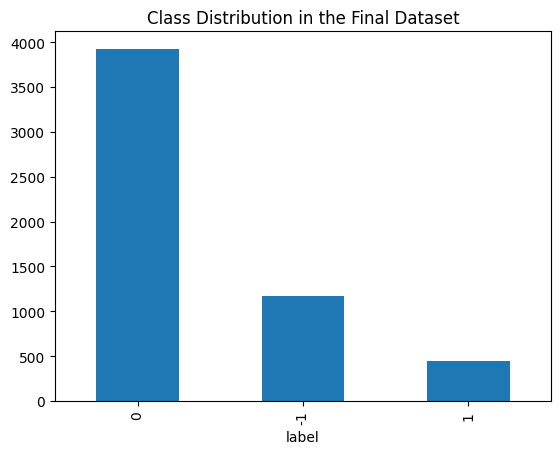

In [71]:
# Visualize the distribution of labels in the final dataset
class_distribution = final_df['label'].value_counts()
print("Class distribution in the final dataset:", class_distribution)
class_distribution.plot(kind='bar', title='Class Distribution in the Final Dataset')

As observed in the above bar chart, the **majority class is 0 (neutral)**, followed by -1 (negative) and 1 (positive). The dataset is unbalanced. Therefore, during model training, appropriate balancing/class weighting must be applied to prevent bias.

<Axes: title={'center': 'Subreddit Distribution in the Final Dataset'}, xlabel='subreddit'>

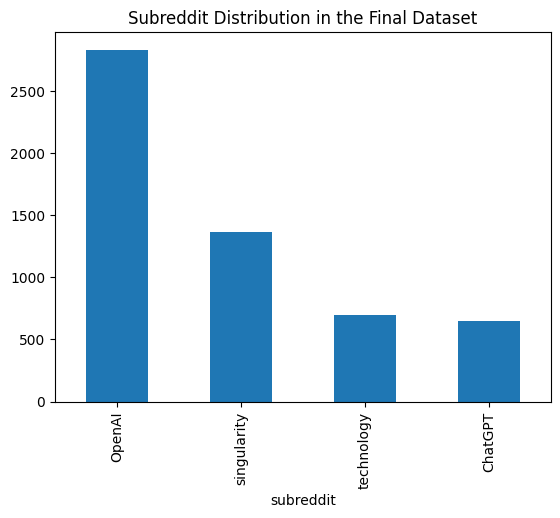

In [72]:
subreddit_distribution = final_df['subreddit'].value_counts()
subreddit_distribution.plot(kind='bar', title='Subreddit Distribution in the Final Dataset')

A large proportion of the data is from the **OpenAI subreddit**, indicating that it's data was considered the most relevant by the semantic retrieval model for our task of OpenAI's reputation analysis. However, the dataset also contains a significant proportion of data from 3 other subreddits: singularity, technology and ChatGPT. This ensures **data diversity**.

<Axes: >

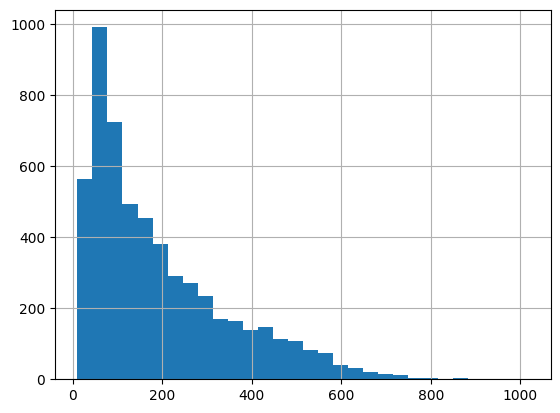

In [78]:
# Plot a histogram of the character count of the text field
final_df['text'].str.len().hist(bins=30)

As we can observe from the histogram, the comments/posts in the data tend to be short, with most of the raw text data being within 400 characters

## 5. Evaluation of Data Selection and Labelling